In [1]:
import csv
import pickle
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from dataclasses import dataclass
from absl import logging
logging.set_verbosity(logging.ERROR)

In [2]:
TEMPERATURES_CSV = 'daily-min-temperatures.csv'

with open(TEMPERATURES_CSV, 'r') as csvfile:
    print(f"Header looks like this:\n\n{csvfile.readline()}")    
    print(f"First data point looks like this:\n\n{csvfile.readline()}")
    print(f"Second data point looks like this:\n\n{csvfile.readline()}")

Header looks like this:

"Date","Temp"

First data point looks like this:

"1981-01-01",20.7

Second data point looks like this:

"1981-01-02",17.9



In [3]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [10]:
temperatures = []
with open(TEMPERATURES_CSV) as csvfile:
    reader = csv.reader(csvfile, delimiter=",")
    next(reader)
    for i in reader:
        temperatures.append(float(i[1]))
    times=[i for i in range(len(temperatures))]

In [13]:
def parse_data_from_file(filename):
    
    times = []
    temperatures = []

    with open(filename) as csvfile:
        
        ### START CODE HERE
        reader = csv.reader(csvfile, delimiter=",")
        next(reader)
        for i in reader:
            temperatures.append(float(i[1]))
            
        times=[i for i in range(len(temperatures))]
        ### END CODE HERE
            
    return times, temperatures

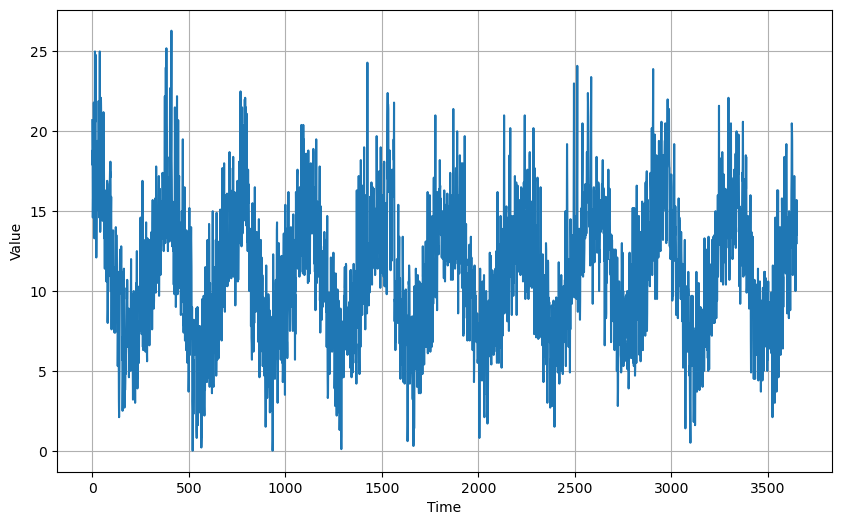

In [15]:
# Test your function and save all "global" variables within the G class (G stands for global)
@dataclass
class G:
    TEMPERATURES_CSV = 'daily-min-temperatures.csv'
    times, temperatures = parse_data_from_file(TEMPERATURES_CSV)
    TIME = np.array(times)
    SERIES = np.array(temperatures)
    SPLIT_TIME = 2500
    WINDOW_SIZE = 64
    BATCH_SIZE = 32
    SHUFFLE_BUFFER_SIZE = 1000


plt.figure(figsize=(10, 6))
plot_series(G.TIME, G.SERIES)
plt.show()

In [17]:
def train_val_split(time, series, time_step=G.SPLIT_TIME):

    time_train = time[:time_step]
    series_train = series[:time_step]
    time_valid = time[time_step:]
    series_valid = series[time_step:]

    return time_train, series_train, time_valid, series_valid


# Split the dataset
time_train, series_train, time_valid, series_valid = train_val_split(G.TIME, G.SERIES)

In [18]:
def windowed_dataset(series, window_size=G.WINDOW_SIZE, batch_size=G.BATCH_SIZE, shuffle_buffer=G.SHUFFLE_BUFFER_SIZE):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1]))
    ds = ds.batch(batch_size).prefetch(1)
    return ds


# Apply the transformation to the training set
train_set = windowed_dataset(series_train, window_size=G.WINDOW_SIZE, batch_size=G.BATCH_SIZE, shuffle_buffer=G.SHUFFLE_BUFFER_SIZE)

In [19]:
def create_uncompiled_model():

    ### START CODE HERE
    
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv1D(128, 3, input_shape=(None, 1)),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
        
        tf.keras.layers.Dense(16),
        tf.keras.layers.Dense(1)
    ]) 
    
    ### END CODE HERE

    return model

In [20]:
# Test your uncompiled model

# Create an instance of the model
uncompiled_model = create_uncompiled_model()

# Get one batch of the training set(X = input, y = label)
for X, y in train_set.take(1):
    
    # Generate a prediction
    print(f'Testing model prediction with input of shape {X.shape}...')
    y_pred = uncompiled_model.predict(X)
    
# Compare the shape of the prediction and the label y (remove dimensions of size 1)
y_pred_shape = y_pred.squeeze().shape

assert y_pred_shape == y.shape, (f'Squeezed predicted y shape = {y_pred_shape} '
                                           f'whereas actual y shape = {y.shape}.')

print("Your current architecture is compatible with the windowed dataset! :)")

Testing model prediction with input of shape (32, 64)...
1/1 [==============================] - 11s 11s/step
Your current architecture is compatible with the windowed dataset! :)


In [21]:
def adjust_learning_rate(dataset):
    
    model = create_uncompiled_model()
    
    lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-4 * 10**(epoch / 20))
    
    ### START CODE HERE
    
    # Select your optimizer
    optimizer = "adam"
    
    # Compile the model passing in the appropriate loss
    model.compile(loss="mse",
                  optimizer=optimizer, 
                  metrics=["mae"]) 
    
    ### END CODE HERE
    
    history = model.fit(dataset, epochs=100, callbacks=[lr_schedule])
    
    return history

In [22]:
# Run the training with dynamic LR
lr_history = adjust_learning_rate(train_set)

Epoch 1/100
77/77 [==============================] - 13s 50ms/step - loss: 63.7411 - mae: 6.8320 - lr: 1.0000e-04
Epoch 2/100
77/77 [==============================] - 3s 33ms/step - loss: 17.6808 - mae: 3.2949 - lr: 1.1220e-04
Epoch 3/100
77/77 [==============================] - 3s 31ms/step - loss: 10.5285 - mae: 2.5073 - lr: 1.2589e-04
Epoch 4/100
77/77 [==============================] - 2s 30ms/step - loss: 8.4953 - mae: 2.2635 - lr: 1.4125e-04
Epoch 5/100
77/77 [==============================] - 2s 31ms/step - loss: 8.1235 - mae: 2.2191 - lr: 1.5849e-04
Epoch 6/100
77/77 [==============================] - 2s 31ms/step - loss: 7.9991 - mae: 2.1983 - lr: 1.7783e-04
Epoch 7/100
77/77 [==============================] - 3s 33ms/step - loss: 7.5668 - mae: 2.1509 - lr: 1.9953e-04
Epoch 8/100
77/77 [==============================] - 3s 34ms/step - loss: 7.1934 - mae: 2.0952 - lr: 2.2387e-04
Epoch 9/100
77/77 [==============================] - 3s 34ms/step - loss: 7.0312 - mae: 2.0809 - lr:

(0.0001, 10.0, 0.0, 10.0)

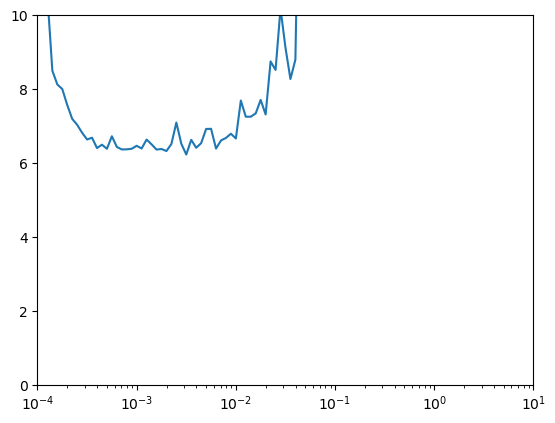

In [23]:
plt.semilogx(lr_history.history["lr"], lr_history.history["loss"])
plt.axis([1e-4, 10, 0, 10])

In [24]:
def create_model():

    
    model = create_uncompiled_model()

    ### START CODE HERE

    model.compile(loss="mse",
                  optimizer="adam",
                  metrics=["mae"])  
    

    ### END CODE HERE

    return model

In [25]:
# Save an instance of the model
model = create_model()

# Train it
history = model.fit(train_set, epochs=50)

Epoch 1/50
77/77 [==============================] - 8s 31ms/step - loss: 24.3421 - mae: 3.7632
Epoch 2/50
77/77 [==============================] - 2s 30ms/step - loss: 9.9055 - mae: 2.4279
Epoch 3/50
77/77 [==============================] - 2s 31ms/step - loss: 7.0929 - mae: 2.0701
Epoch 4/50
77/77 [==============================] - 2s 30ms/step - loss: 6.7631 - mae: 2.0376
Epoch 5/50
77/77 [==============================] - 2s 28ms/step - loss: 6.3859 - mae: 1.9819
Epoch 6/50
77/77 [==============================] - 2s 29ms/step - loss: 6.2945 - mae: 1.9585
Epoch 7/50
77/77 [==============================] - 2s 30ms/step - loss: 6.4829 - mae: 1.9810
Epoch 8/50
77/77 [==============================] - 2s 29ms/step - loss: 6.2470 - mae: 1.9543
Epoch 9/50
77/77 [==============================] - 2s 29ms/step - loss: 6.2358 - mae: 1.9568
Epoch 10/50
77/77 [==============================] - 2s 29ms/step - loss: 6.1784 - mae: 1.9395
Epoch 11/50
77/77 [==============================] - 2s 31

In [26]:
def compute_metrics(true_series, forecast):
    
    mse = tf.keras.metrics.mean_squared_error(true_series, forecast).numpy()
    mae = tf.keras.metrics.mean_absolute_error(true_series, forecast).numpy()

    return mse, mae

## Forecast

In [27]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

113/113 [==============================] - 3s 14ms/step


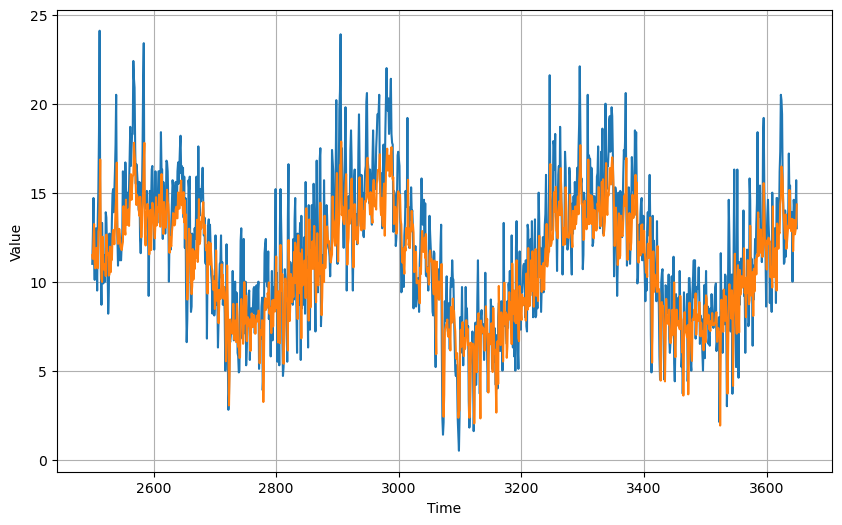

In [28]:
# Compute the forecast for all the series
rnn_forecast = model_forecast(model, G.SERIES, G.WINDOW_SIZE).squeeze()

# Slice the forecast to get only the predictions for the validation set
rnn_forecast = rnn_forecast[G.SPLIT_TIME - G.WINDOW_SIZE:-1]

# Plot the forecast
plt.figure(figsize=(10, 6))
plot_series(time_valid, series_valid)
plot_series(time_valid, rnn_forecast)

In [29]:
mse, mae = compute_metrics(series_valid, rnn_forecast)

print(f"mse: {mse:.2f}, mae: {mae:.2f} for forecast")

mse: 5.70, mae: 1.88 for forecast
